# 4개 모델 성능 비교(통합데이터)
```
    Model         Accuracy Flood Recall  ROC AUC
RandomForest        0.980      0.850      0.970
XGBoost             0.964      0.876      0.977
LSTM+CNN            0.587      0.000      0.769
Transformer+SMOTE   0.740      0.910      0.874

최고의 모델은 RANDOMFOREST(통합)
Transformer+SMOTE는 침수 Recall과 AUC에서 강점을 보이며, 실사용 시 "침수 탐지"가 핵심이라면 매우 효과적

해석 요약 테이블
     모델          Accuracy   Recall    ROC AUC    Precision    F1-score
RandomForest        0.980      0.850     0.970       0.960        0.920
XGBoost             0.964      0.876     0.977       0.816        0.845
LSTM+CNN            0.587      0.000     0.769       0.196        0.320
Transformer+SMOTE   0.740      0.910     0.874       0.290        0.440
```

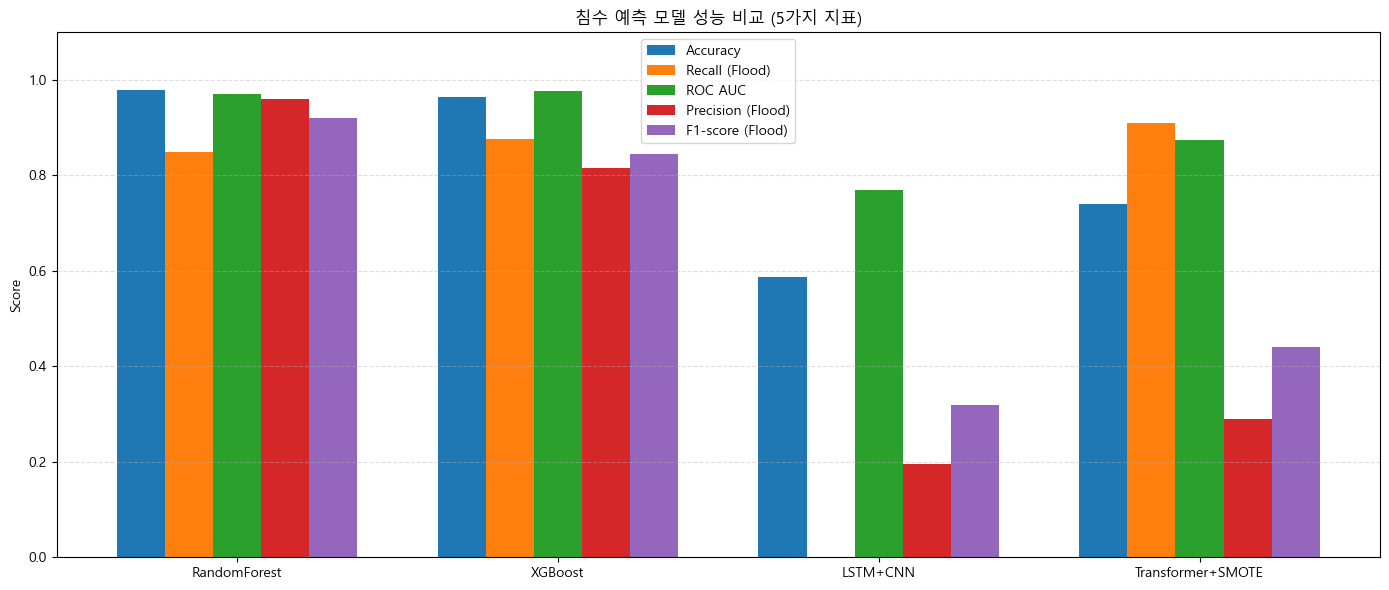

In [10]:
import matplotlib.pyplot as plt

# 모델 이름
models = ["RandomForest", "XGBoost", "LSTM+CNN", "Transformer+SMOTE"]

# 각 성능 지표
accuracy =     [0.980, 0.964, 0.587, 0.740]
recall =       [0.850, 0.876, 0.000, 0.910]   # 침수 Recall
roc_auc =      [0.970, 0.977, 0.769, 0.874]
precision =    [0.960, 0.816, 0.196, 0.290]   # 침수 Precision
f1_score =     [0.920, 0.845, 0.320, 0.440]   # 침수 F1-score

metrics = [accuracy, recall, roc_auc, precision, f1_score]
labels = ["Accuracy", "Recall (Flood)", "ROC AUC", "Precision (Flood)", "F1-score (Flood)"]

x = range(len(models))
bar_width = 0.15

plt.figure(figsize=(14, 6))

for i, metric in enumerate(metrics):
    plt.bar([p + i * bar_width for p in x], metric, width=bar_width, label=labels[i])

plt.xticks([p + 2 * bar_width for p in x], models)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("침수 예측 모델 성능 비교 (5가지 지표)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

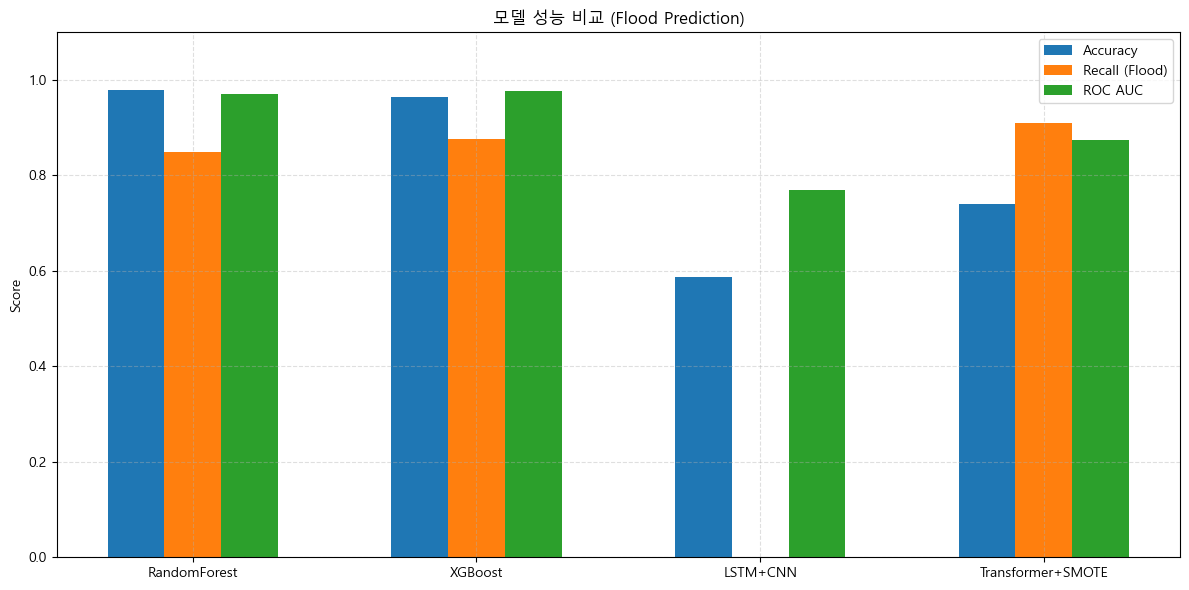

In [9]:
import matplotlib.pyplot as plt

# 모델 이름
models = ["RandomForest", "XGBoost", "LSTM+CNN", "Transformer+SMOTE"]

# 각 모델의 성능 지표
accuracy =     [0.980,     0.964,      0.587,         0.740]
recall_flood = [0.850,     0.876,      0.000,         0.910]  # 침수 클래스 recall
roc_auc =      [0.970,     0.977,      0.769,         0.874]

x = range(len(models))

plt.figure(figsize=(12, 6))

plt.bar(x, accuracy, width=0.2, label='Accuracy', align='center')
plt.bar([i + 0.2 for i in x], recall_flood, width=0.2, label='Recall (Flood)', align='center')
plt.bar([i + 0.4 for i in x], roc_auc, width=0.2, label='ROC AUC', align='center')

plt.xticks([i + 0.2 for i in x], models)
plt.ylim(0, 1.1)
plt.title("모델 성능 비교 (Flood Prediction)")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

# 한글설정, 워닝제거

In [7]:
# 한글설정
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 마이너스(-) 깨짐 방지

#워닝 제거
import warnings
warnings.filterwarnings('ignore')

# api key 활용 및 데이터 수집

In [8]:
import os
from dotenv import load_dotenv
OPENWEATHER_API_KEY = load_dotenv('.env')
OPENWEATHER_API_KEY = os.getenv('OPENWEATHER_API_KEY')
# print(os.getenv('OPENWEATHER_API_KEY'))

# 시간 + 일 데이터 통합 (일 단위 기준)

In [4]:
import pandas as pd

# 1. 시간별 데이터 로딩 및 전처리
hourly = pd.read_csv('asos_seoul_hourly.csv', parse_dates=['tm'])
hourly['date'] = hourly['tm'].dt.date

# 2. 일자료 로딩
daily = pd.read_csv('asos_seoul_daily_with_flood_risk.csv', parse_dates=['tm'])
daily['date'] = daily['tm'].dt.date

# 3. 시간 데이터 요약 (예: 일별 최댓값/평균 등)
hourly_agg = hourly.groupby('date').agg({
    'rn': ['sum', 'max', 'mean'],
    'ws': ['max', 'mean'],
    'ta': ['mean'],
    'hm': ['mean']
})
hourly_agg.columns = ['_'.join(col).strip() for col in hourly_agg.columns.values]
hourly_agg = hourly_agg.reset_index()

# 4. 병합
merged = pd.merge(daily, hourly_agg, on='date', how='inner')

# 5. 불필요한 열 제거 및 정리
merged = merged.drop(columns=['tm'])  # 원래의 'tm' 컬럼 제거하고 date 기준 유지
merged = merged.rename(columns={'date': 'tm'})

# 6. 저장
merged.to_csv("asos_seoul_daily_enriched.csv", index=False)
print(" asos_seoul_daily_enriched.csv 생성 완료")

 asos_seoul_daily_enriched.csv 생성 완료


# RandomForest 통합 (모델저장, 시각화, 평가)

```
컬럼 구성
기본 ASOS 일별 데이터

avgTa, minTa, maxTa : 일평균, 최저, 최고 기온

sumRn : 하루 누적 강수량 (mm)

avgWs, avgRhm, avgTs, avgTd, avgPs : 바람, 습도, 지면온도, 이슬점, 기압 등

tm : 날짜

flood_risk : 침수 위험 (0/1)

추가된 파생 변수 (시간자료 기반 집계)

rn_sum, rn_max, rn_mean : 시간별 강수량 총합, 최고, 평균

ws_max, ws_mean : 풍속 최고/평균

ta_mean, hm_mean : 온도/습도 평균
```

Confusion Matrix:
[[598   0]
 [ 12  66]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       598
           1       1.00      0.85      0.92        78

    accuracy                           0.98       676
   macro avg       0.99      0.92      0.95       676
weighted avg       0.98      0.98      0.98       676


ROC AUC Score: 0.970274847783209


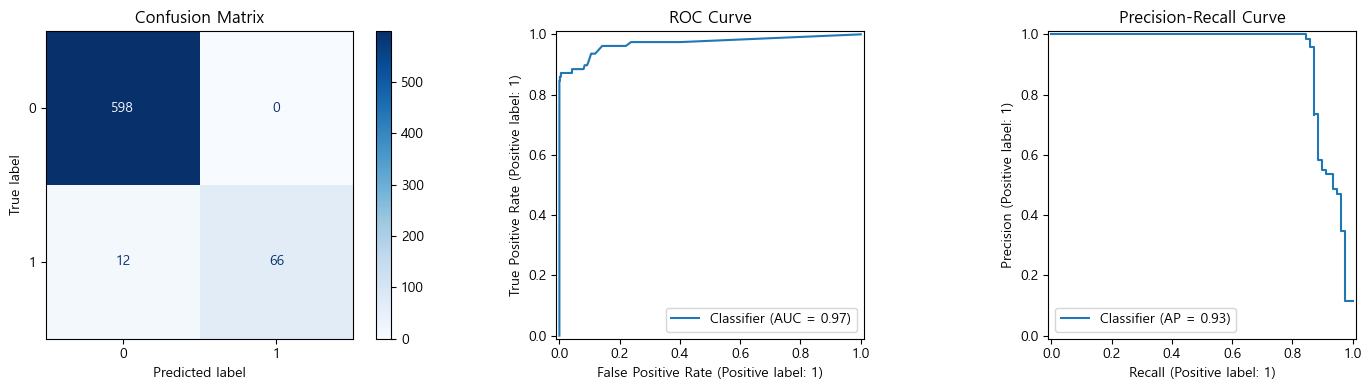

모델 저장 완료: randomforest_enriched_model.pkl


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay
)
import matplotlib.pyplot as plt
import joblib

# 1. 데이터 불러오기
df = pd.read_csv("asos_seoul_daily_enriched.csv", parse_dates=['tm'])

# 2. 결측치 제거
df = df.dropna()

# 3. 특성 / 타겟 분리
X = df.drop(columns=['tm', 'flood_risk'])  # 'tm'은 시계열 인덱스, flood_risk는 타겟
y = df['flood_risk']

# 4. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5. 모델 학습
model = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# 6. 평가
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

# 7. 시각화
plt.figure(figsize=(15, 4))

# Confusion Matrix
plt.subplot(1, 3, 1)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", ax=plt.gca())
plt.title("Confusion Matrix")

# ROC Curve
plt.subplot(1, 3, 2)
RocCurveDisplay.from_predictions(y_test, y_proba, ax=plt.gca())
plt.title("ROC Curve")

# Precision-Recall Curve
plt.subplot(1, 3, 3)
PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=plt.gca())
plt.title("Precision-Recall Curve")

plt.tight_layout()
plt.savefig("randomforest_eval_plots.png")
plt.show()

# 8. 모델 저장
joblib.dump(model, "randomforest_enriched_model.pkl")
print("모델 저장 완료: randomforest_enriched_model.pkl")

# RandomForest (ASOS 일 + 시간 통합 데이터)
```
Metric	Score
Accuracy	0.98
Recall (flood=1)	0.85
Precision (flood=1)	1.00
F1-score (flood=1)	0.92
ROC AUC	0.9703

침수일 예측 성능이 매우 뛰어남
Recall 0.85는 침수일 85%를 감지했다는 의미.

Precision이 1.00이므로 예측한 침수는 모두 진짜 침수 (거짓양성 없음).

전반적으로 ROC AUC 0.97도 우수한 분류기라는 증거.
```